# Creation and Edition of images using Generative AI APIs (Stable Diffusion)

#### Javier Corpus

### Instructions

Use the Stable Diffusion API within a Jupyter Notebook to generate and edit an image. Be sure to include Markdown that describes what you’re doing and a narrative on the result and your thoughts on how easy or hard the API was to use.

The first step is to load all the required libraries to:
 - Load the API key from an `.env` file
 - Send the request to the API and get the response
 - Decode Base64 code into an image (from the API's response), and save it as image

### Part 1: Image Creation

In [1]:
import requests
from PIL import Image
from io import BytesIO
import base64
import os
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("STABILITY_API_KEY")

The following code is where we generate the image, by sending the prompt and the API key to the API endpoint. Besides sending the prompt in the body of the POST request, we are also specifying a style preset ("photographic", in this case), along with the dimensions of the image.

After getting a sucessful response (status code 200), we decode the image (it's Base64 text at this point) and save is as an actual image, with the filename specified.

This function is pretty straightforward.

In [2]:
def generate_image_with_requests(prompt, api_key):

    url = ("https://api.stability.ai/v1/generation"
           "stable-diffusion-xl-1024-v1-0/text-to-image"
    )
    
    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    body = {
        "text_prompts": [
            {
                "text": prompt,
                "weight": 1.0
            }
        ],
        "cfg_scale": 8,
        "height": 1024,
        "width": 1024,
        "samples": 1,
        "steps": 30,
        "style_preset": "photographic"
    }
    
    response = requests.post(url, headers=headers, json=body)
    
    if response.status_code != 200:
        raise Exception(f"Non-200 response: {response.text}")
    
    data = response.json()
    
    for i, image in enumerate(data["artifacts"]):
        img_data = base64.b64decode(image["base64"])
        img = Image.open(BytesIO(img_data))
        filename = f"dragon_soccer_moon_{i}.png"
        img.save(filename)
        print(f"Image saved as {filename}")
        return img
    
    return None

Here we specify the prompt we use to describe the image we want created. Then we call the function defined above, with two parameters: The prompt and the API key that we previously loaded form the `.env` file.

This is also pretty straightforward code.

In [3]:
prompt = ("A dragon playing soccer on the moon."
          "Planet Earth is visible in the background,"
          "photorealistic, high quality, detailed, 4k"
)

# Generate the image using the function defined above
try:
    generated_image = generate_image_with_requests(prompt, api_key)
    print("Image generated successfully!")
except Exception as e:
    print(f"An error occurred: {e}")

Image saved as dragon_soccer_moon_0.png
Image generated successfully!


### Resulting image

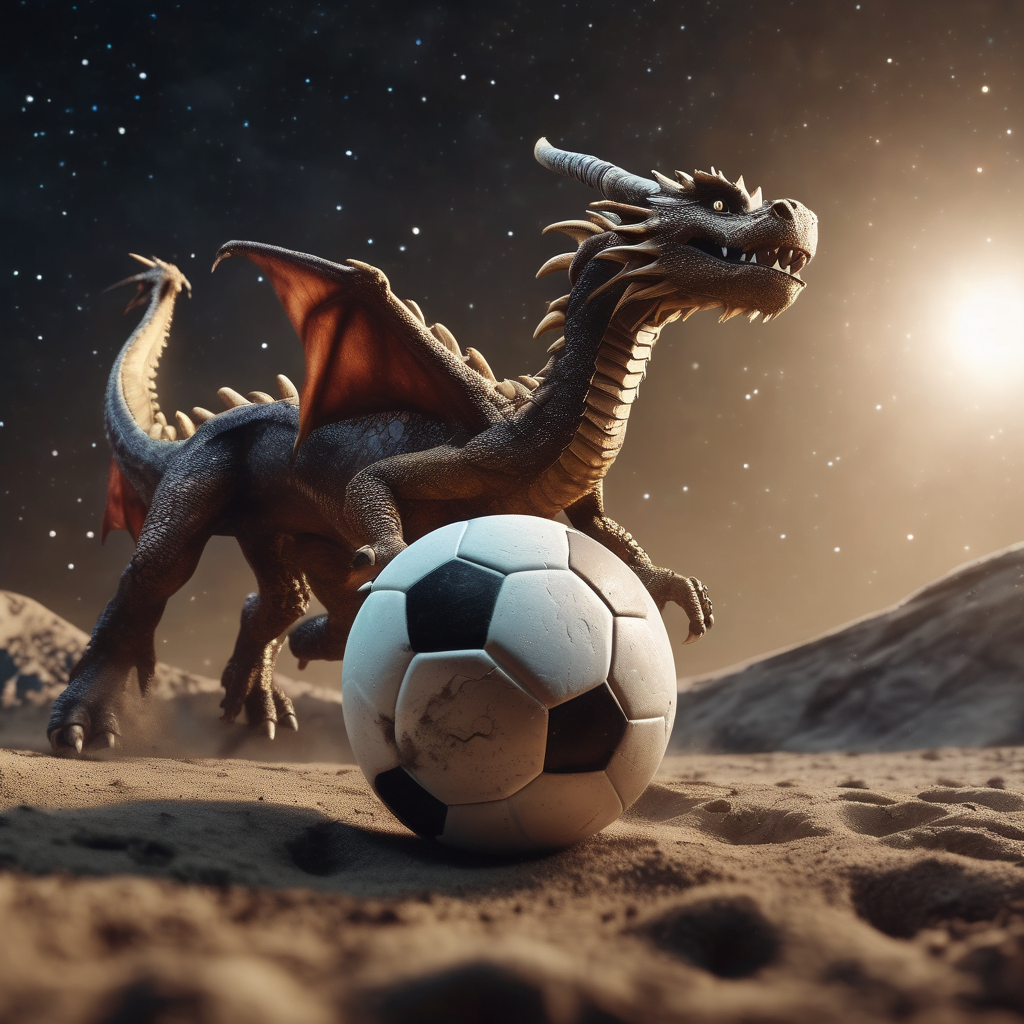

### Part 2: Image Edition

In this second part of the assignment, we take an existing image (the one we created in Part 1), and we edit it using a different API. This is a more complex item, since we need to create a mask to specify where the edit should be.

We start by loading the required libraries.

In [4]:
import requests
import base64
from PIL import Image, ImageDraw
import os

The following function is used to edit an existing image. Here we send the API key, the existing image, the mask, and the filename to save the edited image.

The function itself is also straightforward, there is nothing really complicated about it. It's just another POST request were we send the required parameters.

The complicated part is the mask. This is a mandatory parameter, and creating a mask using code could be complicated. The reason for this is the non-deterministic nature of the GAI, and every time we generate an image, it is different. Even if we keep using the same prompt.

For this exercise, we manually created the mask used to edit the image.

### Mask used

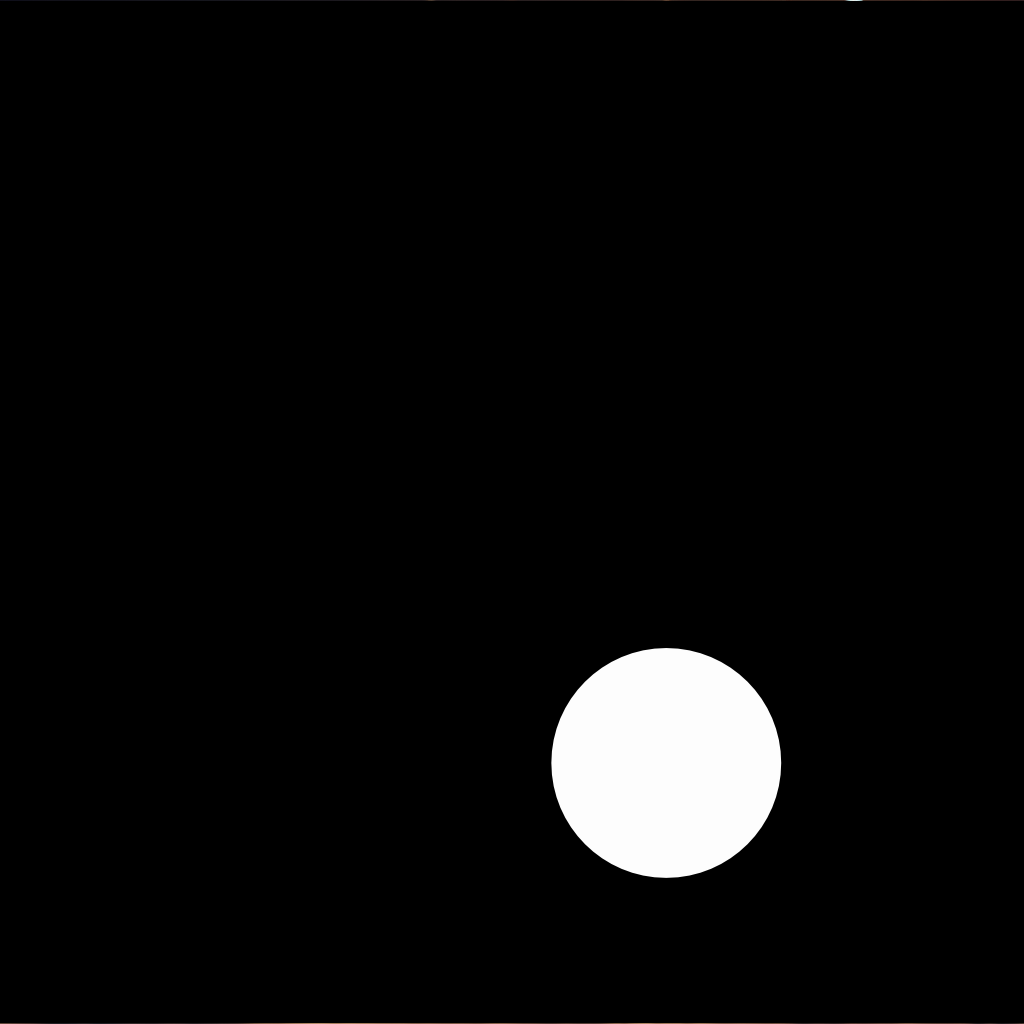

In [5]:
def edit_image_complete(api_key, image_path, mask_path, output_path):

    url = ("https://api.stability.ai/v1/generation"
           "stable-diffusion-xl-1024-v1-0/image-to-image/masking"
    )
    
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Accept": "application/json"
    }
    
    files = {
        "init_image": open(image_path, "rb"),
        "mask_image": open(mask_path, "rb"),
    }
    
    data = {
        "text_prompts[0][text]": ("basketball, orange"
        "basketball with black lines, realistic basketball,"
        "detailed texture"),
        "text_prompts[0][weight]": "1.0",
        "mask_source": "MASK_IMAGE_WHITE",
        "cfg_scale": "7",
        "steps": "30",
        "samples": "1",
    }
    
    print("Sending request to Stability AI API...")
    
    try:
        response = requests.post(url, headers=headers,
        files=files, data=data)
        
        if response.status_code == 200:
            response_data = response.json()
            
            for i, image in enumerate(response_data["artifacts"]):
                image_data = base64.b64decode(image["base64"])
                with open(output_path, "wb") as f:
                    f.write(image_data)
                print(f"Success! Edited image saved as {output_path}")
                return True
        else:
            print(f"Error: {response.status_code}")
            print(f"Response: {response.text}")
            return False
            
    except Exception as e:
        print(f"Exception occurred: {e}")
        return False
    finally:
        if 'init_image' in files:
            files['init_image'].close()
        if 'mask_image' in files:
            files['mask_image'].close()


The following code is also very simple: We are calling the function defined above, sending the required parameters and saving the image.

In [6]:
input_image = "dragon_soccer_moon_0.png"
mask_image = "mask.png"
output_image = "dragon_basketball_moon.png"

print("Editing image...")
success = edit_image_complete(api_key, 
input_image, mask_image, output_image)

if success:
    print("Process completed successfully!")
else:
    print("Process failed. Please check your API key and parameters.")

Editing image...
Sending request to Stability AI API...
Success! Edited image saved as dragon_basketball_moon.png
Process completed successfully!


### Resulting image

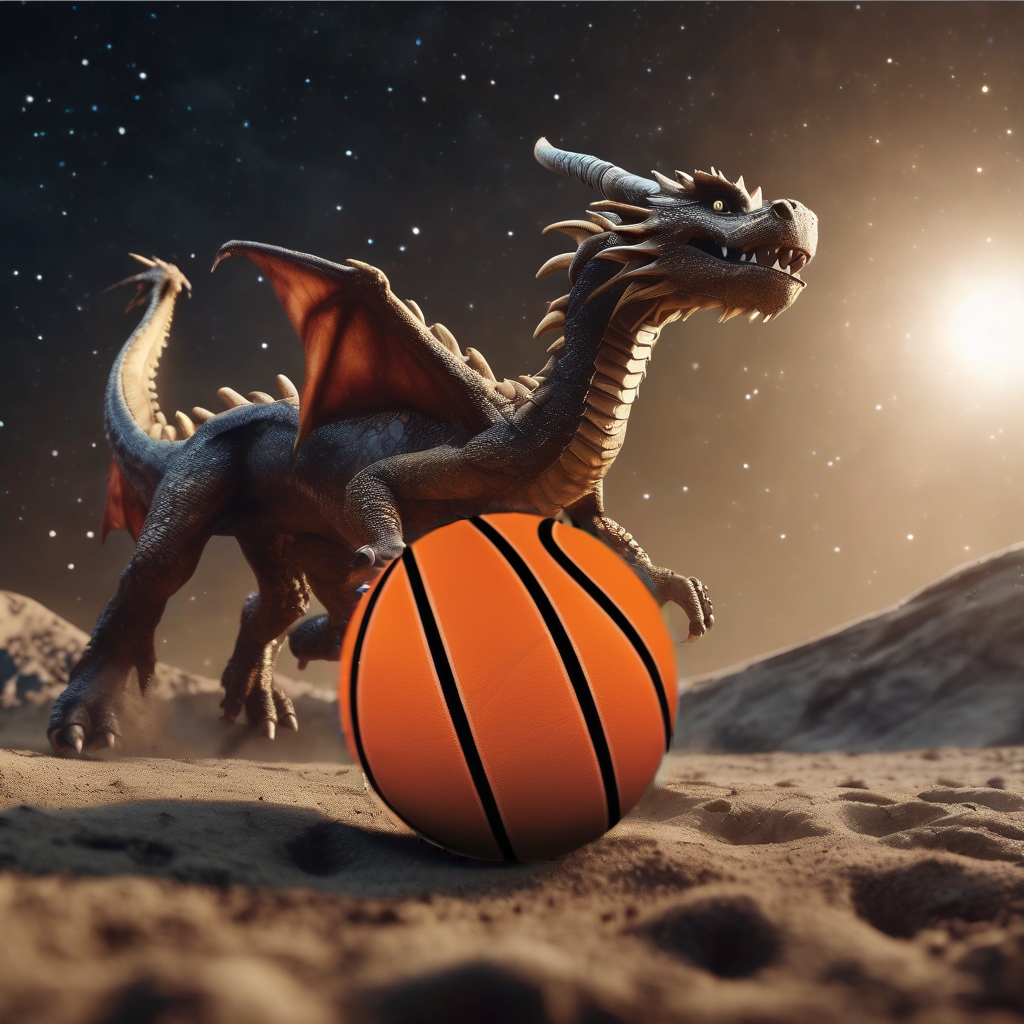

### Conclusion

Generating an image is a very straightforward process, easy to implement. We can add all the details we want in the body of the POST request. Using a loop, we could create as many images as needed. Stable Diffusion created an acceptable image, except for two things: Earth is not visible on the background, and the dragon has a third, weird-looking leg.

Editing an existing image is a very different story. We have to send the image AND a mask to the API endpoint. Due to the non-deterministic nature of GAI, we get a similar (but different) images every time we run the code. This makes really hard to code a dynamic mask.

For this example, we manually created a mask where the soccer ball is. Then, we sent both the image and the mask to the second API with the prompt to create a basket ball. The result is as expected, the soccer ball is replaced by the basket ball.